In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import *
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
import model_utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [24]:
DATA_PATH =  '../../../data/cluster/year/'
HISTORIC_DATA_PATH = '../../../data/cluster/historic/'
OPTIMAL_THRESHOLD = 0.60521042084168331

In [3]:
[[X_train, y_train], 
 [X_valid, y_valid], 
 [X_test, y_test]] = util.load_data(DATA_PATH)

X_train: (529623, 24)
X_valid: (176541, 24)
X_test: (176541, 24)
y_train: (529623, 1)
y_valid: (176541, 1)
y_test: (176541, 1)


In [4]:
X = X_train.append(X_valid).append(X_test)
y = y_train.append(y_valid).append(y_test)
del X_train
del X_valid
del X_test
del y_train
del y_valid
del y_test

In [5]:
def make_squared(dataframe, fields):
    df = dataframe.copy()
    for field in fields:
        df['%s_sq' % field] = df[field] ** 2
    return df

In [6]:
def make_interactions(dataframe, interactions):
    df = dataframe.copy()
    for interaction in interactions:
        main_effects = interaction.split(':')
        df[interaction] = df[main_effects[0]] * df[main_effects[1]]
    return df

In [7]:
sq_fields = [
    'meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug',
    'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan',
    'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual',
    'precip_JunAug', 'precipPrevious_JunAug', 'precip_OctSep',
    'precipPrevious_OctSep', 'precip_growingSeason',
    'elev_etopo1', 'lat', 'lon']
interactions = [
    'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep',
    'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct',
    'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual',
    'precip_OctSep:meanTemp_Aug', 'precip_OctSep:meanMinTemp_Oct',
    'precip_OctSep:elev_etopo1', 'precip_OctSep:elev_etopo1',
    'precip_OctSep:lat', 'precip_OctSep:precip_growingSeason',
    'precip_OctSep:precipPrevious_OctSep',
    'precip_OctSep:precip_meanAnnual', 'precip_OctSep:precip_OctSep',
    'meanMaxTemp_Aug:precip_OctSep', 'meanTemp_AprAug:precip_OctSep',
    'precip_OctSep:varPrecip_growingSeason', 'meanTemp_Aug:precip_OctSep']

In [8]:
X = make_squared(X, sq_fields)
X = make_interactions(X, interactions)

In [9]:
full = X.copy()
full['beetle'] = y['beetle']

In [10]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X = X.drop(
    ['studyArea', 'x', 'y', 'elev_srtm30', 'year', 
     'varPrecip_growingSeason', 'precip_OctSep:varPrecip_growingSeason'], 
    axis=1)

In [11]:
predictors = list(X)
print(predictors)

['meanTemp_Annual', 'meanTemp_AprAug', 'meanTemp_Aug', 'meanMinTemp_DecFeb', 'meanMinTemp_Oct', 'meanMinTemp_Jan', 'meanMinTemp_Mar', 'meanMaxTemp_Aug', 'precip_meanAnnual', 'precip_JunAug', 'vegetation', 'precipPrevious_JunAug', 'precip_OctSep', 'precipPrevious_OctSep', 'precip_growingSeason', 'elev_etopo1', 'lat', 'lon', 'meanTemp_Annual_sq', 'meanTemp_AprAug_sq', 'meanTemp_Aug_sq', 'meanMinTemp_DecFeb_sq', 'meanMinTemp_Oct_sq', 'meanMinTemp_Jan_sq', 'meanMinTemp_Mar_sq', 'meanMaxTemp_Aug_sq', 'precip_meanAnnual_sq', 'precip_JunAug_sq', 'precipPrevious_JunAug_sq', 'precip_OctSep_sq', 'precipPrevious_OctSep_sq', 'precip_growingSeason_sq', 'elev_etopo1_sq', 'lat_sq', 'lon_sq', 'meanMinTemp_Oct:precip_OctSep', 'precip_meanAnnual:precip_OctSep', 'precip_OctSep:precipPrevious_OctSep', 'meanTemp_Aug:meanMinTemp_Oct', 'precip_OctSep:lon', 'precip_OctSep:precip_growingSeason', 'precip_OctSep:meanMaxTemp_Aug', 'meanMinTemp_Oct:precip_meanAnnual', 'precip_OctSep:meanTemp_Aug', 'precip_OctSep:m

In [12]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
y = y['beetle'].values.reshape(-1)

# Baseline Logistic Regression 
#### With L1 (_Lasso Regression_) or L2 (_Ridge Regression_ ) Regularization
This model will be considered the baseline for logistic regression models as it uses just the raw predictors.  After some EDA, various transformations and interaction terms will also be considered in order to improve the model.

In [14]:
logistic_clf = LogisticRegression(C=0.001, penalty='l2')
logistic_clf.fit(X, y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
coefs = pd.DataFrame(
    [[pred, coef] 
     for pred, coef in zip(predictors, logistic_clf.coef_[0])], 
    columns=['predictor', 'coef'])
coefs['abs'] = np.abs(coefs.coef)
coefs = coefs.sort_values('abs', ascending=False)
coefs = coefs.drop(['abs'], axis=1)
coefs

,predictor,coef
10,vegetation,1.252718
18,meanTemp_Annual_sq,-1.000793
16,lat,0.868577
19,meanTemp_AprAug_sq,-0.837075
7,meanMaxTemp_Aug,0.792203
20,meanTemp_Aug_sq,-0.756262
21,meanMinTemp_DecFeb_sq,-0.655956
23,meanMinTemp_Jan_sq,-0.597047
39,precip_OctSep:lon,0.564877
9,precip_JunAug,-0.552219


In [16]:
def get_ranges(data, verbose=False):
    xrange = data.x.min(), data.x.max()
    yrange = data.y.min(), data.y.max()
    if verbose:
        print('x range:', xrange, '\ny range:', yrange)
    return xrange, yrange

In [17]:
x_range, y_range = get_ranges(full, verbose=True)

x range: (-2070000.0, -200000.0) 
y range: (-2000000.0, 1520000.0)


In [18]:
def mask_data(data, xrange, yrange, verbose=False):
    if verbose:
        print('Input data:')
        get_ranges(data, verbose)
    data = data.loc[(data.x >= xrange[0])
                    & (data.x <= xrange[1])
                    & (data.y >= yrange[0])
                    & (data.y <= yrange[1]), :]
    if verbose:
        print('Output data:')
        get_ranges(data, verbose)
    return data

In [19]:
def find_extra_rows(data, xy):
    remove = []
    for row in data.index:
        data_xy = str(data.loc[row, 'x']) + str(data.loc[row, 'y'])
        if data_xy not in list(xy):
            remove.append(row)
    return remove

In [22]:
historic_years = range(1998, 2000)
year = 1999 # <- !

next_year_data = full.loc[full.year == (year + 1), :]

#hist_data = pd.read_csv(HISTORIC_DATA_PATH + 'clean_%d.csv' % year) 
#hist_data = mask_data(hist_data, x_range, y_range, verbose=False)

#hist_merge = full[['x', 'y']]

In [42]:
while year >= historic_years[0]:
    hist_data = pd.read_csv(HISTORIC_DATA_PATH + 'clean_%d.csv' % year) 
    hist_data = mask_data(hist_data, x_range, y_range, verbose=False)
    hist_data = make_squared(hist_data, sq_fields)
    hist_data = make_interactions(hist_data, interactions)

    print('\nBeginning predictions for', year)
    xy = next_year_data.apply(
        lambda row: str(row['x']) + str(row['y']), axis=1)
    print('  Reducing %d data to study area...' % year)
    extras = find_extra_rows(hist_data, xy)
    hist_data = hist_data.drop(extras, axis=0)
    hist_data = hist_data.rename(
        columns={'precipPreious_OctSep': 'precipPrevious_OctSep'})
    if year == historic_years[-1]:
        hist_merge = hist_data[['x', 'y']]
    print('  Ascertaining rows are aligned...')
    assert list(hist_data.x) == list(next_year_data.x)
    assert list(hist_data.y) == list(next_year_data.y)

    hist_data.index = next_year_data.index
    hist_merge.index = hist_data.index
    hist_essentials = pd.DataFrame(hist_data[predictors[0]])
    print('  Keeping essentials...')
    for p in predictors[1:]:
        hist_essentials[p] = hist_data[p]

    hist_essentials = scaler.fit_transform(hist_essentials)
    print('  Predicting...')
    probs = logistic_clf.predict_proba(hist_essentials)
    probs = np.array([prob[1] for prob in probs])
    #hist_data['beetle'] = probs
    hist_merge.loc[:, 'probs_%d' % year] = probs
    hist_merge.loc[:, 'preds_%d' % year] = list(map(
        lambda x: 1 if x >= OPTIMAL_THRESHOLD else 0, probs))
    year -= 1
    next_year_data = hist_data

hist_merge.head()


Beginning predictions for 1999
  Reducing 1999 data to study area...
  Ascertaining rows are aligned...
  Keeping essentials...
  Predicting...


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value



Beginning predictions for 1998
  Reducing 1998 data to study area...
  Ascertaining rows are aligned...
  Keeping essentials...
  Predicting...


/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,x,y,probs_1999,preds_1999,probs_1998,preds_1998
0,-1550000.0,-2000000.0,0.000552,0,0.000519,0
1,-1540000.0,-2000000.0,0.000483,0,0.000455,0
2,-1530000.0,-2000000.0,0.000387,0,0.000366,0
3,-1520000.0,-2000000.0,0.000877,0,0.000882,0
4,-1510000.0,-2000000.0,0.000765,0,0.000774,0


In [43]:
m_1999 = util.column2matrix(hist_merge, 'preds_1999')
m_1998 = util.column2matrix(hist_merge, 'preds_1998')

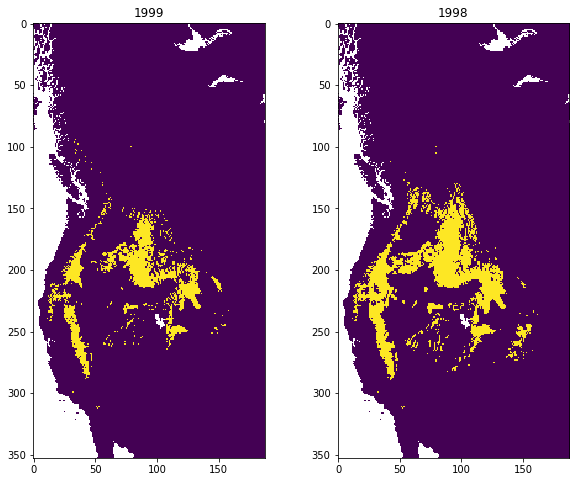

In [44]:
plt.subplot(121);
imshow(np.rot90(m_1999));
plt.title('1999');
plt.subplot(122);
imshow(np.rot90(m_1998));
plt.title('1998');

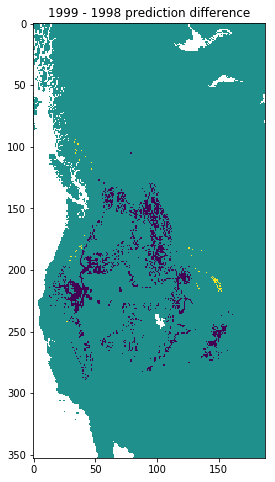

In [45]:
m_diff = m_1999 - m_1998
imshow(np.rot90(m_diff));
plt.title('1999 - 1998 prediction difference');

In [46]:
m_1999 = util.column2matrix(hist_merge, 'probs_1999')
m_1998 = util.column2matrix(hist_merge, 'probs_1998')

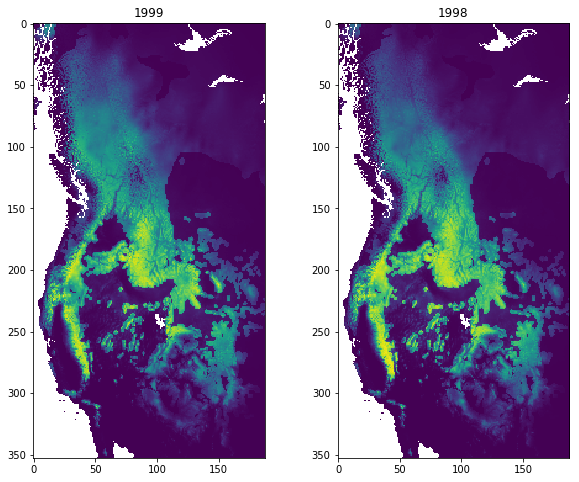

In [47]:
plt.subplot(121);
imshow(np.rot90(m_1999));
plt.title('1999');
plt.subplot(122);
imshow(np.rot90(m_1998));
plt.title('1998');

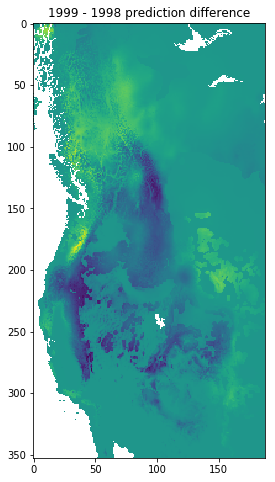

In [48]:
m_diff = m_1999 - m_1998
imshow(np.rot90(m_diff));
plt.title('1999 - 1998 prediction difference');